In [2]:
%matplotlib inline
import os

from pathlib import Path
from tensorflow.python.summary.summary_iterator import summary_iterator

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.errors import DataLossError

In [3]:
image_extension = 'eps'

In [4]:
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

In [34]:
notebooks_dir = Path(os.path.abspath(''))
logs_dir = notebooks_dir.parent / 'hierarchical_algos' / 'logs'
logs_dagger_dir = notebooks_dir.parent / 'hierarchical_algos' / 'logsDagger'
media_dir = notebooks_dir.parent / 'media'

demos_log_dir = notebooks_dir.parent / 'hierarchical_algos' / 'demos' / 'logs'

new_logs_dir = notebooks_dir / 'data' / 'logs'

# HAC-General With Teacher

In [4]:
lunar_lander_event_file1 = str(logs_dir / 'LunarLanderContinuous-v2' / 'May28_17-19-13' / 'events.out.tfevents.1590679155.thebox.1855205.0')
lunar_lander_event_file2 = str(logs_dir / 'LunarLanderContinuous-v2' / 'May28_19-13-32' / 'events.out.tfevents.1590686013.thebox.2105456.0')
lunar_lander_event_files = [lunar_lander_event_file1, lunar_lander_event_file2]

mountain_car_event_file1 = str(logs_dir / 'MountainCarContinuous-v0' / 'May30_01-23-42' / 'events.out.tfevents.1590794626.thebox.1200713.0')
mountain_car_event_files = [mountain_car_event_file1]

In [9]:
# This example supposes that the events file contains summaries with a
# summary value tag 'loss'.  These could have been added by calling
# `add_summary()`, passing the output of a scalar summary op created with
# with: `tf.scalar_summary(['loss'], loss_tensor)`.

def get_vals_with_tag(event_file_name, tag_name):
    values = []
    try:
        for index, e in enumerate(summary_iterator(event_file_name)):
            for v in e.summary.value:
                if v.tag == tag_name:
                    values.append(v.simple_value)
    except DataLossError as err:
        print("DataLossError: {0}".format(err))
        print(f"Stop reading new records and return the {len(values)} values that were read")
        print("We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted")

    
    return values

def get_all_tags(event_file_name):
    tags = set()
    try:
        for index, e in enumerate(summary_iterator(event_file_name)):
            for v in e.summary.value:
                tags.add(v.tag)
    except DataLossError as err:
        print("DataLossError: {0}".format(err))
        print(f"Stop reading new records and return the {len(tags)} tags that were read")
        print("We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted")
            
    return tags

In [16]:
sns.set()
sns.set_style("whitegrid")

def make_running_rewards_plot(event_files, env_name, reward_threshold, algorithm, tag='Progress/Running reward', scaling_factor = 1):
    running_rewards_list = [get_vals_with_tag(event_file, tag) for event_file in event_files]
    display_running_rewards_plot(running_rewards_list, env_name, reward_threshold, algorithm, scaling_factor)
    
def display_running_rewards_plot(running_rewards_list, env_name, reward_threshold, algorithm, scaling_factor = 1, run_label=None):
    plt.figure(figsize=(12, 6))
    for index, running_rewards in enumerate(running_rewards_list):
        plt.plot(running_rewards[:5000], label=run_label or f"Run {index}")
        

    plt.xlabel("Episode")
    if scaling_factor == 1:
        plt.ylabel("Running reward")
    else:
        plt.ylabel(f"Running reward (scaling factor = {scaling_factor})")
        
    plt.title(f"Evolution of the running reward - {env_name} environment")
    plt.axhline(y=reward_threshold, color='r', linestyle='-', label="Success threshold")
    plt.legend()
    plt.savefig(media_dir / f"RunningReward{env_name.replace(' ', '')}{algorithm}.{image_extension}")
    plt.show()

def display_percentage_reached_subgoals_plot(event_files, env_name, algorithm, smoothing_weight=0.6):
    subgoals_percentages_list = [get_vals_with_tag(event_file, 'Subgoals/Subgoal success') for event_file in event_files]

    def smooth(scalars, weight):  # Weight between 0 and 1
        last = scalars[0]  # First value in the plot (first timestep)
        smoothed = list()
        for point in scalars:
            smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
            smoothed.append(smoothed_val)                        # Save it
            last = smoothed_val                                  # Anchor the last smoothed value

        return smoothed
    
    
    plt.figure(figsize=(12, 6))
    for index, percentages in enumerate(subgoals_percentages_list):
        smoothed_percentages = smooth(percentages[:2000], smoothing_weight)
        plt.plot(smoothed_percentages, label=f"Run {index}")
        

    plt.xlabel("Episode")
    plt.ylabel("Smoothed percentage of subgoals that were reached")
    plt.title(f"Smoothed evolution of the percentage of subgoals that were reached - {env_name} environment")
    plt.legend()
    plt.savefig(media_dir / f"ReachedSubgoal{env_name.replace(' ', '')}{algorithm}.{image_extension}")
    plt.show()

def display_performance_plot(running_rewards_list, env_name, reward_threshold, algorithm, scaling_factor = 1, run_label=None, training=True, episode_multiplier=1, quantity=None):
    x = [i * episode_multiplier + 1 for i in range(len(running_rewards_list[0]))]
    
    plt.figure(figsize=(12, 6))
    for index, running_rewards in enumerate(running_rewards_list):
        plt.plot(x, running_rewards, label=run_label or f"Run {index}")
    
    

    plt.xlabel("Episode")
    if scaling_factor == 1:
        plt.ylabel(f"{quantity or 'Episode reward'}")
    else:
        plt.ylabel(f"{quantity or 'Episode reward'} (scaling factor = {scaling_factor})")
        
    train_str = "training" if training else "testing"
    
    plt.title(f"Episode reward during a {train_str} phase - {env_name} environment")
    plt.axhline(y=reward_threshold, color='r', linestyle='-', label="Success threshold")
    plt.legend()
    plt.savefig(media_dir / f"EpisodeReward{env_name.replace(' ', '')}{algorithm}{train_str.capitalize()}.{image_extension}", dpi=300)
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


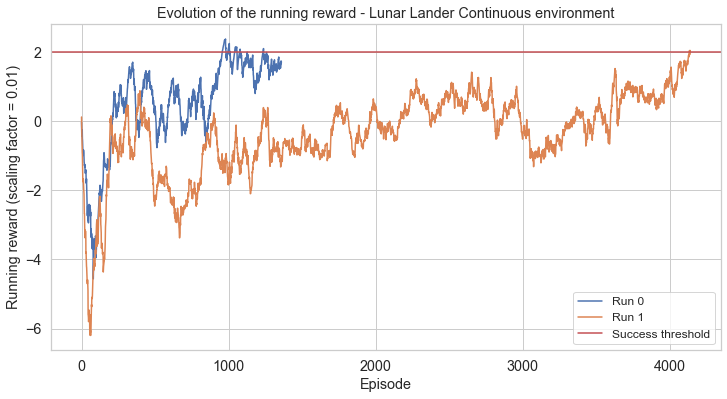

In [40]:
make_running_rewards_plot(
    lunar_lander_event_files, 
    env_name='Lunar Lander Continuous', 
    reward_threshold=2, 
    algorithm = 'HacGeneralWithTeacher',
    scaling_factor=0.01
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


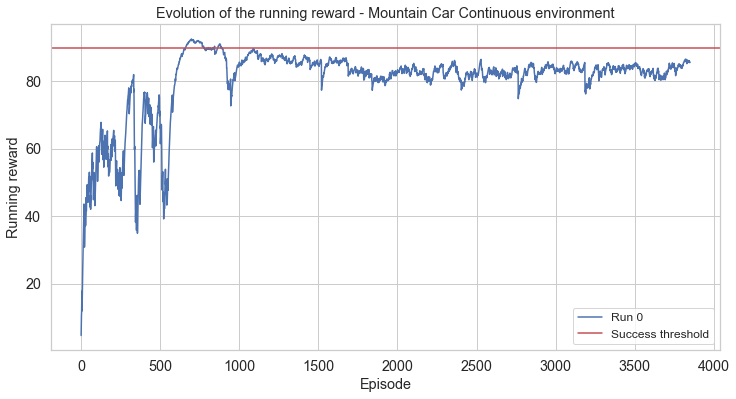

In [41]:
make_running_rewards_plot(
    mountain_car_event_files, 
    env_name='Mountain Car Continuous', 
    reward_threshold=90, 
    algorithm = 'HacGeneralWithTeacher',
)

## Stats about reaching the goal

In [42]:
demos_log_dir = notebooks_dir.parent / 'hierarchical_algos' / 'demos' / 'logs'

lunar_lander_demo_event_file = str(demos_log_dir / 'LunarLanderContinuous-v2' / 'Jul04_20-01-18' / 'events.out.tfevents.1593885681.thebox.2061222.0')
mountain_car_demo_event_file = str(demos_log_dir / 'MountainCarContinuous-v0' / 'Jul04_20-08-21' / 'events.out.tfevents.1593886104.thebox.2080334.0')

In [43]:
percentage_subgoals_reached_mc = get_vals_with_tag(mountain_car_demo_event_file, 'Subgoals/Subgoal success')

DataLossError: truncated record at 5181412
Stop reading new records and return the 336 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted


In [44]:
percentage_subgoals_reached_ll = get_vals_with_tag(lunar_lander_demo_event_file, 'Subgoals/Subgoal success')

DataLossError: truncated record at 30988195
Stop reading new records and return the 696 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


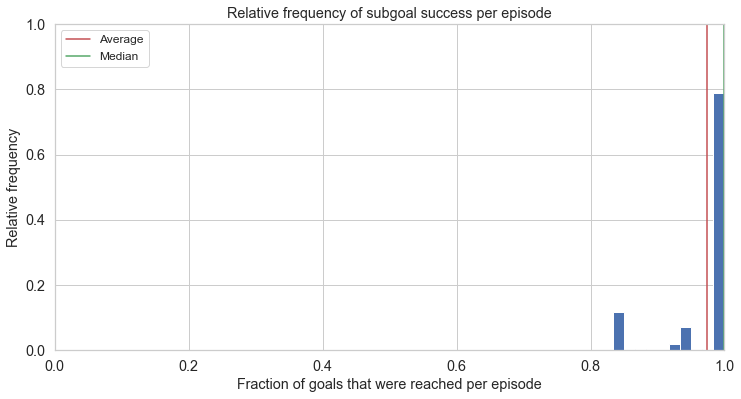

In [45]:
plt.figure(figsize=(12, 6))

def get_weights(data):
    return np.zeros_like(data) + 1. / len(data)

plt.hist(percentage_subgoals_reached_mc, weights=get_weights(percentage_subgoals_reached_mc))
plt.title('Relative frequency of subgoal success per episode')
plt.xlabel('Fraction of goals that were reached per episode')
plt.ylabel('Relative frequency')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axvline(np.average(percentage_subgoals_reached_mc), label='Average', color='r')
plt.axvline(np.median(percentage_subgoals_reached_mc), label='Median', color='g')
plt.legend()
plt.savefig(media_dir / f"SubgoalSuccesMountainCar.{image_extension}", dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


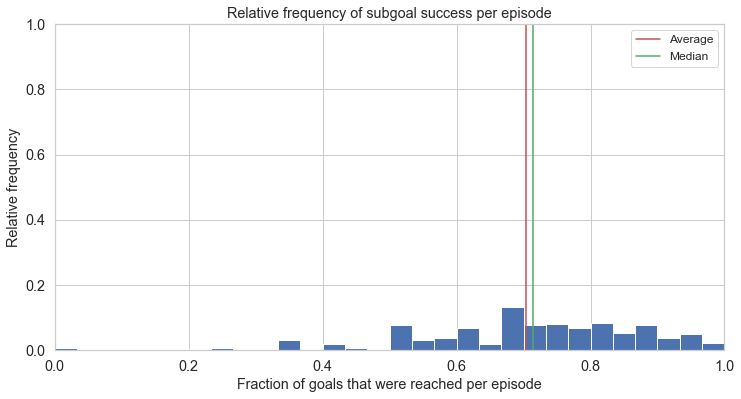

In [46]:
plt.figure(figsize=(12, 6))
plt.hist(percentage_subgoals_reached_ll, weights=get_weights(percentage_subgoals_reached_ll), bins=30)
plt.title('Relative frequency of subgoal success per episode')
plt.xlabel('Fraction of goals that were reached per episode')
plt.ylabel('Relative frequency')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axvline(np.mean(percentage_subgoals_reached_ll), label='Average', color='r')
plt.axvline(np.median(percentage_subgoals_reached_ll), label='Median', color='g')
plt.legend()
plt.savefig(media_dir / f"SubgoalSuccesLunarLander.{image_extension}", dpi=300)

In [47]:
np.mean(percentage_subgoals_reached_mc)

0.9745216846820854

In [48]:
print(len(percentage_subgoals_reached_mc))

336


In [49]:
np.mean(percentage_subgoals_reached_ll)

0.7034615315925116

In [50]:
print(len(percentage_subgoals_reached_ll))

696


# HAC-General (without Teacher)

In [51]:
lunar_lander_no_teacher_event_file_1 = str(logs_dir / 'LunarLanderContinuous-v2' / 'Jun20_01-56-07' / 'events.out.tfevents.1592610968.thebox.2211291.0')
lunar_lander_no_teacher_event_file_2 = str(logs_dir / 'LunarLanderContinuous-v2' / 'Jun20_14-35-39' / 'events.out.tfevents.1592656542.thebox.3264987.0')
lunar_lander_no_teacher_event_files = [lunar_lander_no_teacher_event_file_1, lunar_lander_no_teacher_event_file_2]

mountain_car_no_teacher_event_file_1 = str(logs_dir / 'MountainCarContinuous-v0' / 'Jun21_23-02-22' / 'events.out.tfevents.1592773345.thebox.2029788.0')
mountain_car_no_teacher_event_file_2 = str(logs_dir / 'MountainCarContinuous-v0' / 'Jun23_10-55-01' / 'events.out.tfevents.1592902504.thebox.448039.0')
mountain_car_no_teacher_event_files = [mountain_car_no_teacher_event_file_1, mountain_car_no_teacher_event_file_2]

DataLossError: truncated record at 212699621
Stop reading new records and return the 5709 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


DataLossError: truncated record at 265980051
Stop reading new records and return the 5811 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted


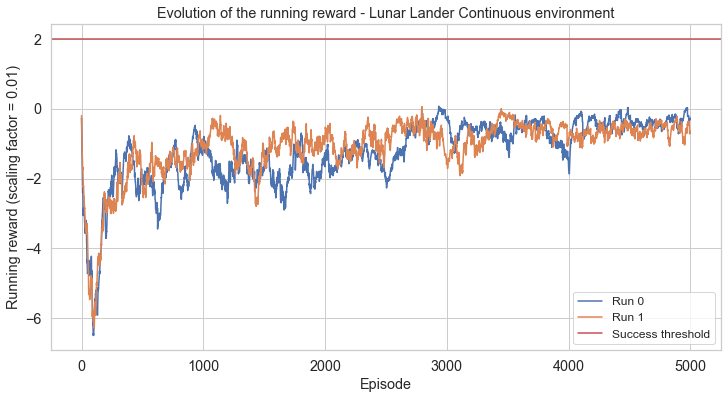

In [52]:
make_running_rewards_plot(
    lunar_lander_no_teacher_event_files, 
    env_name='Lunar Lander Continuous', 
    reward_threshold=2, 
    algorithm = 'HacGeneralWithoutTeacher',
    scaling_factor=0.01
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


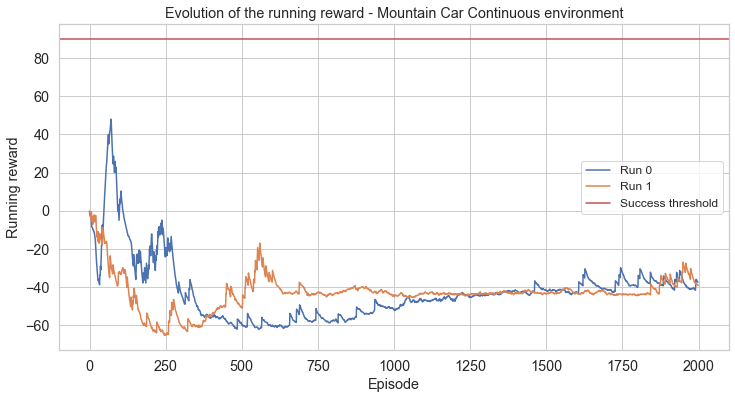

In [53]:
make_running_rewards_plot(
    mountain_car_no_teacher_event_files, 
    env_name='Mountain Car Continuous', 
    reward_threshold=90, 
    algorithm = 'HacGeneralWithoutTeacher',
)

DataLossError: truncated record at 212699621
Stop reading new records and return the 6665 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted
DataLossError: truncated record at 265980051
Stop reading new records and return the 6781 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


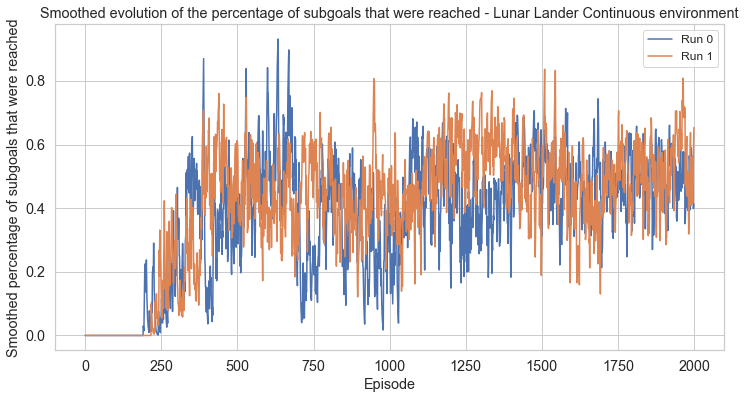

In [54]:
display_percentage_reached_subgoals_plot(
    lunar_lander_no_teacher_event_files, 
    env_name='Lunar Lander Continuous', 
    algorithm = 'HacGeneralWithoutTeacher',
    smoothing_weight=0.7
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


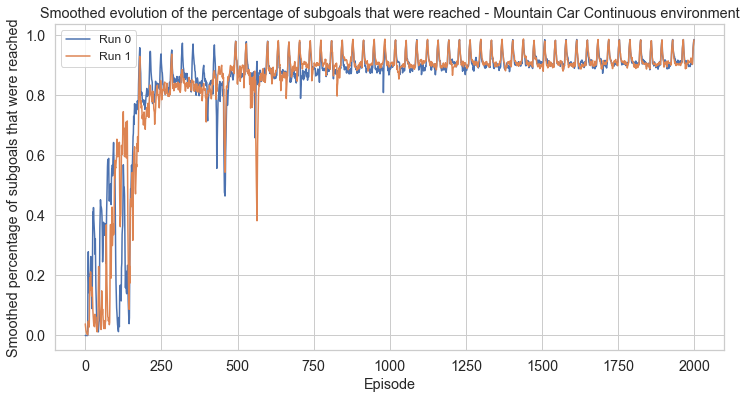

In [55]:
display_percentage_reached_subgoals_plot(
    mountain_car_no_teacher_event_files, 
    env_name='Mountain Car Continuous', 
    algorithm = 'HacGeneralWithoutTeacher',
    smoothing_weight=0.7
)

In [56]:
get_all_tags(lunar_lander_no_teacher_event_files[0])

DataLossError: truncated record at 212699621
Stop reading new records and return the 56 tags that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted


{'Action/(Level 0) 0 ',
 'Action/(Level 0) 1 ',
 'Action/Predicted reward (Level 1)',
 'Eval/Mean number of steps',
 'Eval/Mean reward',
 'Eval/Std dev number of steps',
 'Eval/Success rate',
 'Level 0/Done',
 'Level 0/Failed to reach goal',
 'Level 0/Steps per episode',
 'Level 0/Total reward',
 'Level 1/Done',
 'Level 1/Steps per episode',
 'Level 1/Total reward',
 'Loss/(Level 0) Log Prob',
 'Loss/(Level 0) Policy',
 'Loss/(Level 0) Predicted 1',
 'Loss/(Level 0) Predicted 2',
 'Loss/(Level 0) Reward',
 'Loss/(Level 0) Target',
 'Loss/(Level 0) Value',
 'Loss/(Level 0) Values 1',
 'Loss/(Level 0) Values 2',
 'Loss/(Level 1) Log Prob',
 'Loss/(Level 1) Policy',
 'Loss/(Level 1) Predicted 1',
 'Loss/(Level 1) Predicted 2',
 'Loss/(Level 1) Reward',
 'Loss/(Level 1) Target',
 'Loss/(Level 1) Value',
 'Loss/(Level 1) Values 1',
 'Loss/(Level 1) Values 2',
 'Progress/Episode reward',
 'Progress/Num episodes steps',
 'Progress/Running reward',
 'Q-values/Normal (Level 0) Network 1',
 'Q-v

# Dagger

In [57]:
lunar_lander_event_file_dagger = str(logs_dagger_dir / 'LunarLanderContinuous-v2' / 'Jun15_23-40-22' / 'events.out.tfevents.1592257223.thebox.2492523.0')
lunar_lander_event_files_dagger = [lunar_lander_event_file_dagger]
lunar_lander_event_file_dagger

'/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/hierarchical_algos/logsDagger/LunarLanderContinuous-v2/Jun15_23-40-22/events.out.tfevents.1592257223.thebox.2492523.0'

In [58]:
get_all_tags(lunar_lander_event_file_dagger)

{'TestingPhase/Episode reward',
 'TestingPhase/Eval Mean Num Steps',
 'TestingPhase/Eval Mean Percent goals reached',
 'TestingPhase/Eval Mean Reward',
 'TestingPhase/Eval Std Dev Num Steps',
 'TestingPhase/Eval Std Dev Reward',
 'TestingPhase/Eval Std Percent goals reached',
 'TestingPhase/Percent goals reached',
 'TestingPhase/Steps in episode',
 'TrainingPhase/Episode reward',
 'TrainingPhase/Eval Mean Num Steps',
 'TrainingPhase/Eval Mean Percent goals reached',
 'TrainingPhase/Eval Mean Reward',
 'TrainingPhase/Eval Std Dev Num Steps',
 'TrainingPhase/Eval Std Dev Reward',
 'TrainingPhase/Eval Std Percent goals reached',
 'TrainingPhase/Percent goals reached',
 'TrainingPhase/Steps in episode'}

In [59]:
running_rewards_list = [get_vals_with_tag(event_file, 'TestingPhase/Episode reward') for event_file in lunar_lander_event_files_dagger]
running_rewards_list;

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


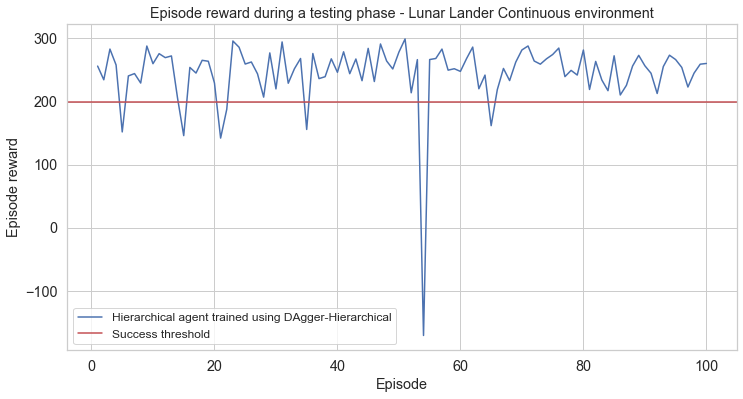

In [60]:
display_performance_plot(
    running_rewards_list, 
    env_name='Lunar Lander Continuous', 
    reward_threshold=200, 
    algorithm = 'DAgger-Hierarchical',
    run_label = "Hierarchical agent trained using DAgger-Hierarchical",
    training = False
)

In [61]:
running_rewards_list_train = [get_vals_with_tag(event_file, 'TrainingPhase/Eval Mean Reward') for event_file in lunar_lander_event_files_dagger]
running_rewards_list_train;

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


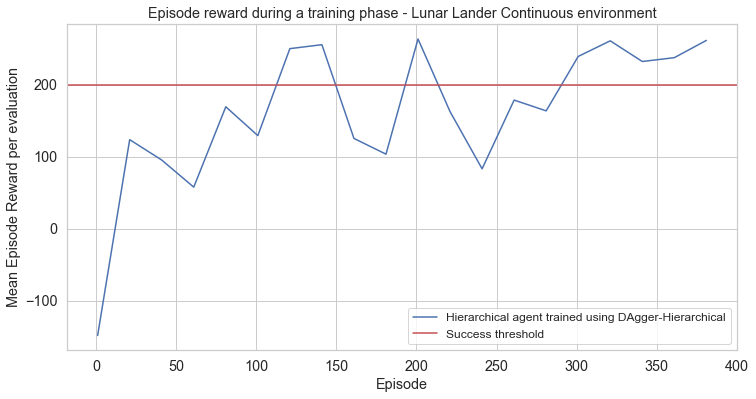

In [62]:
display_performance_plot(
    running_rewards_list_train, 
    env_name='Lunar Lander Continuous', 
    reward_threshold=200, 
    algorithm = 'DAgger-Hierarchical',
    run_label = "Hierarchical agent trained using DAgger-Hierarchical",
    quantity = "Mean Episode Reward per evaluation",
    episode_multiplier = 20,
    training = True
)

# New stats from cluster

In [57]:
mountain_car_files_paths = list(new_logs_dir.glob('**/MountainCarContinuous-v0/Aug02_15*/*.0'))
mountain_car_files_paths

[PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/MountainCarContinuous-v0/Aug02_15-02-17/events.out.tfevents.1596373339.node379.hydra.os.265280.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/MountainCarContinuous-v0/Aug02_15-02-38/events.out.tfevents.1596373360.node379.hydra.os.17544.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/MountainCarContinuous-v0/Aug02_15-02-59/events.out.tfevents.1596373381.node379.hydra.os.84094.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/MountainCarContinuous-v0/Aug02_15-03-23/events.out.tfevents.1596373405.node378.hydra.os.90620.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/MountainCarContinuous-v0/Aug02_15-03-41/events.out.tfevents.1596373423.node376.hydra.os.301184.0')]

In [53]:
mountain_car_files = [str(path) for path in mountain_car_files_paths]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


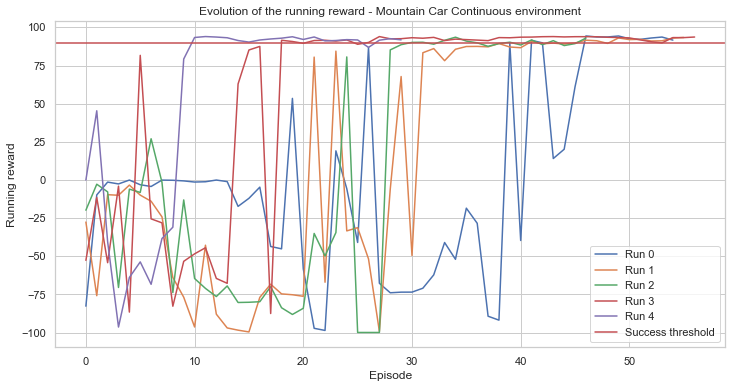

In [54]:
make_running_rewards_plot(
    mountain_car_files, 
    env_name='Mountain Car Continuous', 
    reward_threshold=90, 
    algorithm = 'HacGeneralWithTeacher',
    scaling_factor=1,
    tag='Eval/Mean_reward'
    #tag='Progress/Running_reward'
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


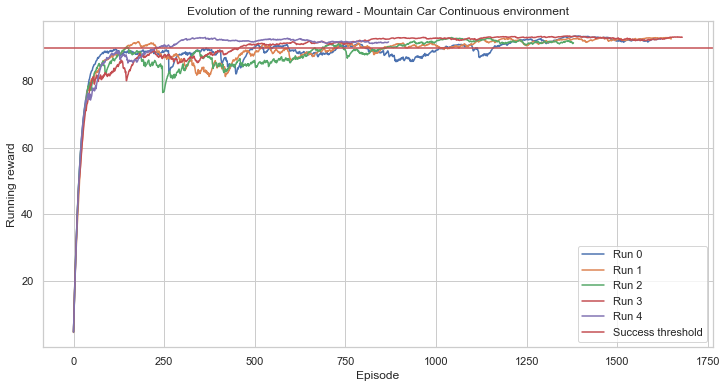

In [55]:
make_running_rewards_plot(
    mountain_car_files, 
    env_name='Mountain Car Continuous', 
    reward_threshold=90, 
    algorithm = 'HacGeneralWithTeacher',
    scaling_factor=1,
    #tag='Eval/Mean_reward'
    tag='Progress/Running_reward'
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


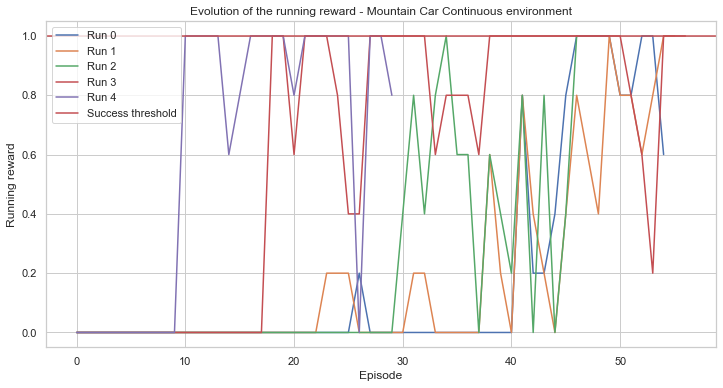

In [56]:
make_running_rewards_plot(
    mountain_car_files, 
    env_name='Mountain Car Continuous', 
    reward_threshold=1, 
    algorithm = 'HacGeneralWithTeacher',
    scaling_factor=1,
    tag='Eval/Success_rate'
)

In [ ]:
get_all_tags(mountain_car_files[0])

###  Lunar Lander

In [59]:
lunar_lander_files_paths = list(new_logs_dir.glob('**/LunarLanderContinuous-v2/Aug02_19*/*.0'))
lunar_lander_files_paths

[PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug02_19-20-54/events.out.tfevents.1596388867.node381.hydra.os.256660.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug02_19-21-05/events.out.tfevents.1596388867.node381.hydra.os.257199.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug02_19-21-43/events.out.tfevents.1596388905.node378.hydra.os.15591.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug02_19-22-02/events.out.tfevents.1596388925.node378.hydra.os.76867.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug02_19-22-23/events.out.tfevents.1596388946.node376.hydra.os.41987.0')]

In [60]:
lunar_lander_files = [str(path) for path in lunar_lander_files_paths]

DataLossError: truncated record at 86280701
Stop reading new records and return the 134 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted
DataLossError: truncated record at 88671807
Stop reading new records and return the 132 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted
DataLossError: truncated record at 97800815
Stop reading new records and return the 129 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted
DataLossError: truncated record at 100154441
Stop reading new records and return the 128 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


DataLossError: truncated record at 44955364
Stop reading new records and return the 58 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted


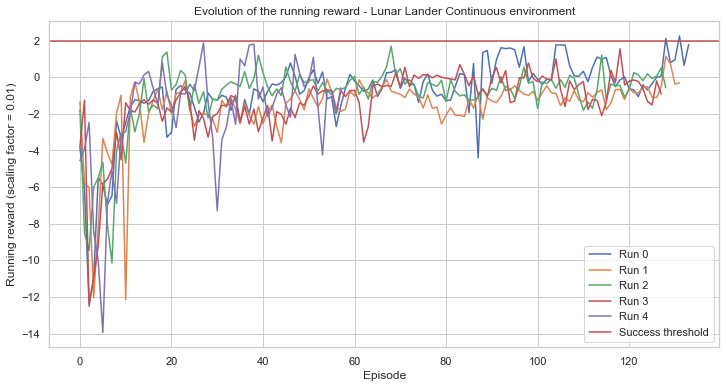

In [69]:
make_running_rewards_plot(
    lunar_lander_files, 
    env_name='Lunar Lander Continuous', 
    reward_threshold=2, 
    algorithm = 'HacGeneralWithTeacher',
    scaling_factor=0.01,
    tag='Eval/Mean_reward'
    #tag='Progress/Running_reward'
)

DataLossError: truncated record at 86280701
Stop reading new records and return the 4010 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted
DataLossError: truncated record at 88671807
Stop reading new records and return the 3945 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted
DataLossError: truncated record at 97800815
Stop reading new records and return the 3844 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted
DataLossError: truncated record at 100154441
Stop reading new records and return the 3830 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


DataLossError: truncated record at 44955364
Stop reading new records and return the 1716 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted


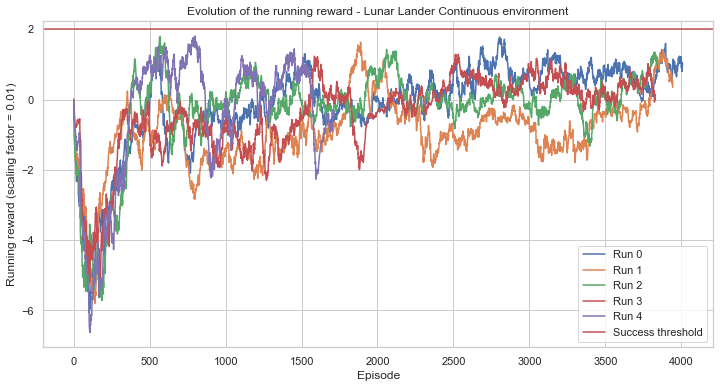

In [70]:
make_running_rewards_plot(
    lunar_lander_files, 
    env_name='Lunar Lander Continuous', 
    reward_threshold=2, 
    algorithm = 'HacGeneralWithTeacher',
    scaling_factor=0.01,
    tag='Progress/Running_reward'
)

DataLossError: truncated record at 86280701
Stop reading new records and return the 134 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted
DataLossError: truncated record at 88671807
Stop reading new records and return the 132 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted
DataLossError: truncated record at 97800815
Stop reading new records and return the 129 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted
DataLossError: truncated record at 100154441
Stop reading new records and return the 128 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


DataLossError: truncated record at 44955364
Stop reading new records and return the 58 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted


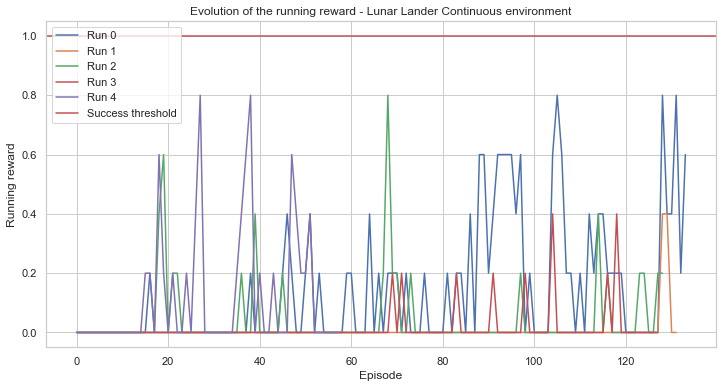

In [72]:
make_running_rewards_plot(
    lunar_lander_files, 
    env_name='Lunar Lander Continuous', 
    reward_threshold=1, 
    algorithm = 'HacGeneralWithTeacher',
    scaling_factor=1,
    tag='Eval/Success_rate'
)

## Fast time estimation

In [21]:
episode_rate = 90 / 20.0  # 90 episodes in 20 minutes
episode_rate

4.5

In [22]:
total_number_episodes = 1000

In [24]:
num_minutes = total_number_episodes / episode_rate
num_minutes

222.22222222222223

In [32]:
def print_time(num_minutes):
    hours = int(num_minutes // 60)
    minutes = num_minutes % 60
    print(f"{hours:} hours and {minutes:.1f} minutes to execute {total_number_episodes} episodes")

print_time(num_minutes)

3 hours and 42.2 minutes to execute 1000 episodes


We will be save and do a 3x slowdown, since it's often much slower as the training progresses.
This makes it about 10 hours

In [33]:
print_time(num_minutes * 3)

11 hours and 6.7 minutes to execute 1000 episodes


That's roughly eleven hours!